# Bucket Pricing

The main idea is to clean the distributions of the categories included in the data (each CategoryDesc and Manufacturer will be considered as a different category), to create groups of similar categories using the **Kolmogorov-Smirnoff test**.

Then, having groups of similar categories, create buckets for the ones that has not too much variance.

The data will have filters, given by Michael Keim's team

- Sales from June 2020 to December 2020
- Min sold price of $5
- Exclude 271+
- All item conditions
- LTV filter >= 20% and <=80%
- 20 or more transactions (we will need evaluate further based on the addition of all item conditions) 
- Exclude items discounted by 25% or more (Total Discount)
- Exclude manufacturers that are beneath 80% of the category composition
- In an effort to remove erroneous manufacturer names/bad data
- Don’t group categories
- Categories that use attributes can we use the KS method to find similarities in distributions - and if they can be grouped?
- Use IQR Fences
- 30 or more transactions that meet the above criteria

#  Libraries

In [1]:
library(ggplot2)
library(dplyr)
library(forcats)
library(readr)
library(factoextra)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



# Read Data

In [2]:
data <- read_csv('/Users/darias/Documents/Bucket_Pricing/Data/bucket_pricing_data_May20_Dec20.csv')

Parsed with column specification:
cols(
  .default = col_character(),
  primary_relation = col_double(),
  FiscalYear = col_double(),
  sold_price = col_double(),
  tax = col_double(),
  ItemID = col_double(),
  cost = col_double(),
  item_categorization = col_double(),
  Inventory_Days = col_double()
)

See spec(...) for full column specifications.

Warning message:
“1 parsing failure.
   row  col expected actual                                                                              file
589282 cost a double   NULL '/Users/darias/Documents/Bucket_Pricing/Data/bucket_pricing_data_May20_Dec20.csv'
”


In [3]:
data$date <- substr(data$origindate,1,10) %>% as.Date

Example of 1 row of the data

In [4]:
head(data,1) %>% t

[,1]                     
Country             USA                      
primary_relation    429931859                
gid                 19176567                 
origindate          2020-09-10 18:05:18 +0000
FiscalYear          2020                     
original_price      49.9900016784668         
sold_price          35.99                    
tax                 0                        
Item_ezid           180241228557             
ItemID              506468785                
cost                35                       
item_categorization 555002                   
Primary             General Merchandise      
Secondary           Household/Office Goods   
Tertiary            Appliance                
CategoryDesc        Electric Heater          
item_type           GM                       
store               18024                    
transType           Sales                    
customerType        Customer                 
Inventory_Days      192                      
Manufacturer        DYNA-GLO                 
Model_Number        DELUXE                   
item_cond           B                        
date                2020-09-10

Manufacturer in lowercase, without spaces

In [5]:
data %>%
 mutate(Manufacturer = tolower(Manufacturer),
        Manufacturer = gsub(' ', '', Manufacturer)) -> data

In [6]:
f0 <- c(nrow(data),length(unique(paste0(data$CategoryDesc,data$Manufacturer))))

# Cleaning  Data

## Drop big categories

The business wants buckets for "other stuff", so it will be dropped categories like:
 - TVs
 - Videogames
 - Tablets
 - Cellphones
 - Laptop

In [7]:
x <- c(
'Video Game Console',
'Laptop',
'LED',
'Digital OLED TVs',
'LCD',
'Tablet',
'Smart Phones',
'Cellular Telephone',
'null',
'Shoes',
'NULL')

In [8]:
data %>%
 filter(!(CategoryDesc %in% x)) -> data

Drop Manufacturer in NULL

In [9]:
data %>%
 filter(Manufacturer != 'null', !is.na(Manufacturer),
        CategoryDesc != 'null', !is.na(CategoryDesc)) -> data

In [10]:
f1 <- c(nrow(data),length(unique(paste0(data$CategoryDesc,data$Manufacturer))))

## June 2020 and forward

In [11]:
data %>%
 filter(date >= as.Date('2020-06-01'),date <= as.Date('2020-12-31')) -> data

In [12]:
f2 <- c(nrow(data),length(unique(paste0(data$CategoryDesc,data$Manufacturer))))

## Sold price > 5 dlls

For the business, every item sold <= 5 dlls has no importance, so will be filtered

In [13]:
data %>%
 filter(sold_price >= 5) -> data

In [14]:
f3 <- c(nrow(data),length(unique(paste0(data$CategoryDesc,data$Manufacturer))))

## Sold in first 271 days

In [15]:
data %>%
 filter(Inventory_Days <= 271) -> data

In [16]:
f4 <- c(nrow(data),length(unique(paste0(data$CategoryDesc,data$Manufacturer))))

## LTV filter

Just items with LTV between 20% and 80%

In [17]:
data %>%
 mutate(LTV = cost/sold_price) %>%
 filter(LTV >= 0.2, LTV <= 0.8) -> data


In [18]:
f5 <- c(nrow(data),length(unique(paste0(data$CategoryDesc,data$Manufacturer))))

## Create Category

Paste the Manufacturer and the CategoryDesc to create the Categories

In [19]:
data %>%
 mutate(CategoryDesc_original = CategoryDesc,
        CategoryDesc          = paste0(Manufacturer,'-',CategoryDesc)) -> data

## 20 items

To have reasonable distributions, only will be considered CategoryDesc with at least 20 items

In [20]:
data %>%
 group_by(CategoryDesc) %>%
 mutate(n = n()) %>%
 filter(n >= 20) %>%
 select(-n) -> data

In [21]:
f6 <- c(nrow(data),length(unique(data$CategoryDesc)))

## Discount < 25%

In [22]:
options(warn=-1)
data %>%
 mutate(dct = 1 - (as.numeric(sold_price)/as.numeric(original_price))) %>%
 filter(dct < 0.25, !is.na(dct))  %>%
 select(-dct) -> data

In [23]:
f7 <- c(nrow(data),length(unique(data$CategoryDesc)))

## 80% of Manufacturers by CategoryDesc

In [24]:
#data %>%
# filter(Manufacturer != 'null') %>%
# group_by(CategoryDesc_original,Manufacturer) %>%
# tally %>%
# ungroup %>%
# group_by(CategoryDesc_original) %>%
# mutate(total = sum(n)) %>%
# ungroup %>%
# mutate(pct = n/total) %>%
# group_by(CategoryDesc_original) %>%
# arrange(desc(pct)) %>%
# group_by(CategoryDesc_original) %>%
# mutate(cum_sum = cumsum(pct)) %>%
# filter(cum_sum <= 0.8) %>%
# ungroup %>%
# mutate(CategoryDesc = paste0(Manufacturer,'-',CategoryDesc_original)) %>%
# select(CategoryDesc) %>%
# pull %>%
# unique -> above80

In [25]:
#data %>%
# filter(CategoryDesc %in% above80) -> data


In [26]:
#f8 <- c(nrow(data),length(unique(data$CategoryDesc)))


## Drop outliers

Left and right outliers will be dropped, using the boxplot filters

In [27]:
LimInf_fun <- function(x){
    a <- boxplot(x, plot = FALSE)
    
    b <- a$stats[1]
    
    return(b)
}

In [28]:
LimSup_fun <- function(x){
    a <- boxplot(x, plot = FALSE)
    
    b <- a$stats[5]
    
    return(b)
}

In [29]:
data %>%
 group_by(CategoryDesc) %>%
 mutate(lim_inf = LimInf_fun(sold_price),
        lim_sup = LimSup_fun(sold_price)) %>%
 ungroup %>%
 filter(sold_price > lim_inf, sold_price < lim_sup) %>%
 select(-lim_inf, -lim_sup) -> data

In [30]:
f9 <- c(nrow(data),length(unique(data$CategoryDesc)))

# Waterfall

Plot with the number of rows and unique CategoryDesc and Manufacturer

In [31]:
data.frame(rbind(f0,f1,f2,f3,f4,f5,f6,f7,#f8,
                 f9)) -> wf

names(wf) <- c('Rows','Distinct_CatMan')

desc <- c('No Filter',
          'Drop big categories',
          'June20-Dec20',
          'Sold Price >= $5',
          'Sold first 271 days',
          'LTV filter',
          '20 transactions',
          'Discount <= 25%',
          #'80% Manufactures Dist',
          'Boxplot Outliers')

wf$desc <- desc
wf$desc <- fct_inorder(wf$desc)

## Total rows

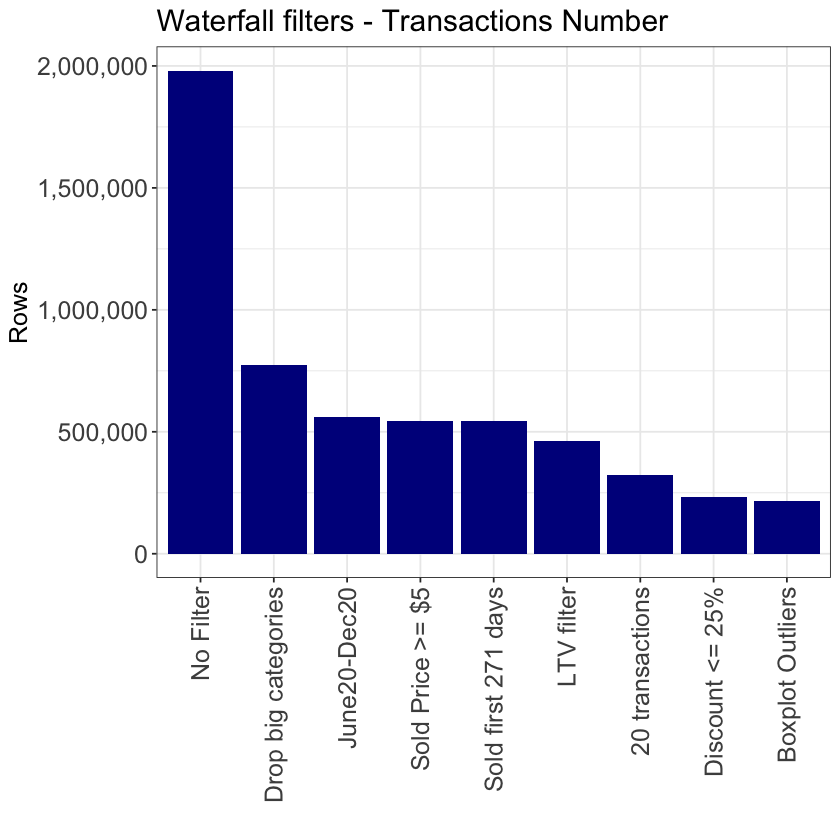

In [32]:
wf %>%
 ggplot() +
 geom_col(aes(x = desc, y = Rows), fill = 'darkblue') +
 ggtitle('Waterfall filters - Transactions Number') +
 theme_bw() +
 xlab('') +
 theme(axis.text.x  = element_text(size = 15, angle = 90, hjust = 1, vjust = 0.5),
       axis.text.y  = element_text(size = 15),
       axis.title.x = element_text(size = 15),
       axis.title.y = element_text(size = 15),
       title        = element_text(size = 15),
       legend.position = 'none') +
 scale_y_continuous(labels = scales::comma)

## Unique Manufacturer-CategoryDesc

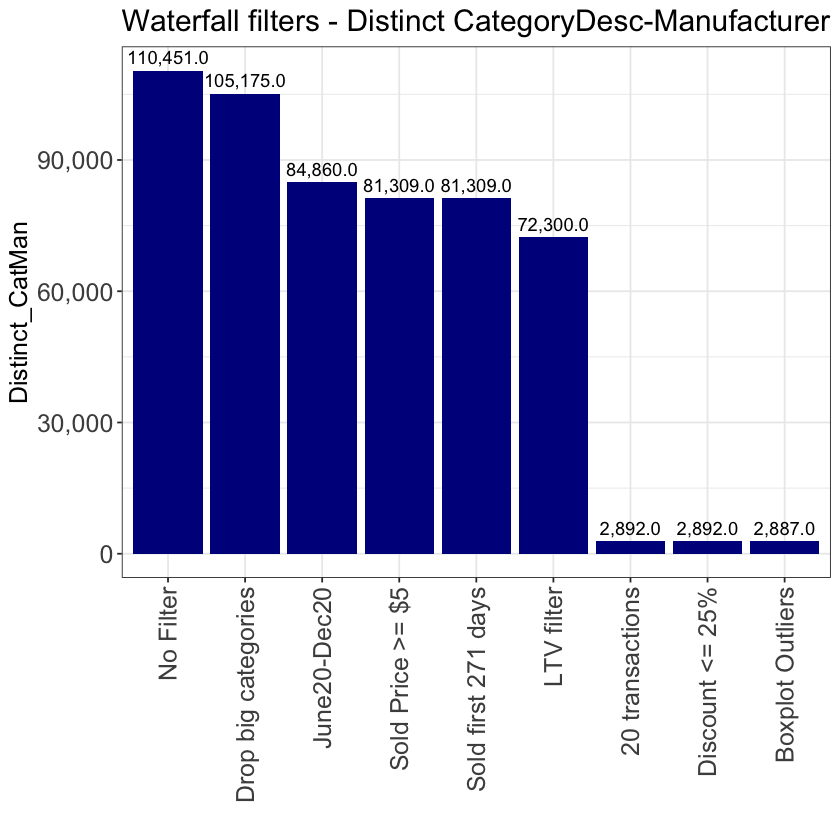

In [33]:
wf %>%
 ggplot() +
 geom_col(aes(x = desc, y = Distinct_CatMan), fill = 'darkblue') +
 ggtitle('Waterfall filters - Distinct CategoryDesc-Manufacturer') +
 theme_bw() +
 xlab('') +
 theme(axis.text.x  = element_text(size = 15, angle = 90, hjust = 1, vjust = 0.5),
       axis.text.y  = element_text(size = 15),
       axis.title.x = element_text(size = 15),
       axis.title.y = element_text(size = 15),
       title        = element_text(size = 15),
       legend.position = 'none') +
 scale_y_continuous(labels = scales::comma) +
 geom_text(aes(x     = desc,
               y     = Distinct_CatMan, 
               label = scales::comma(Distinct_CatMan)), vjust = -0.5)

# KS Test

Calculate the **Kolmogorov-Smirnoff p-value** for each combination of CategoryDesc

Create a data frame with all possible combinations of Category Desc

In [34]:
cd <- unique(data$CategoryDesc)

In [35]:
expand.grid.unique <- function(x, y, include.equals=FALSE)
{
    x <- unique(x)

    y <- unique(y)

    g <- function(i)
    {
        z <- setdiff(y, x[seq_len(i-include.equals)])

        if(length(z)) cbind(x[i], z, deparse.level=0)
    }

    do.call(rbind, lapply(seq_along(x), g))
}

In [36]:
expand.grid.unique(cd,cd) %>%
 as.data.frame %>%
 mutate(V1 = as.character(V1),
        V2 = as.character(V2)) -> comb

In [37]:
comb$ks <- NA
comb$ds <- NA

In [38]:
nrow(comb)


[1] 4165941

In [ ]:
options(warn=-1)
for(i in 1:nrow(comb)){
    cat1 <- comb$V1[i]
    cat2 <- comb$V2[i]
    
    data %>%
     filter(CategoryDesc == cat1) %>%
     select(sold_price) %>%
     pull -> d1
    
    data %>%
     filter(CategoryDesc == cat2) %>%
     select(sold_price) %>%
     pull -> d2
    
    ks <- ks.test(d1,d2)
    
    comb$ks[i] <- ks$p.value
    comb$ds[i] <- ks$statistic %>% as.vector()
    
    
    # Print iterations to see the advance of the for loop
    g <- seq(100000,800000,by = 100000)
    if(i %in% g){print(i)}
    
    
}

In [39]:
setwd('/Users/darias/Documents/Bucket_Pricing/Data_Out/')


In [48]:
write.csv(comb,file = 'CategoryDesc_ManufacturerKS_TimFilter_Jun20Dec20_20t.csv',row.names = FALSE)


In [60]:
#comb <- read_csv('/Users/darias/Documents/Bucket_Pricing/Data_Out/CategoryDesc_ManufacturerKS_TimFilter_Jun20Dec20_20t.csv')

Parsed with column specification:
cols(
  V1 = col_character(),
  V2 = col_character(),
  ks = col_double()
)



## Example of similar distributions

In [61]:
comb %>% filter(ks >= 0.05) %>% filter(grepl('dewalt-Cordless Drill',V1)) %>% head


V1                    V2                                        ks        
1 dewalt-Cordless Drill casio-Instrumental Keyboard               0.68163163
2 dewalt-Cordless Drill mitutoyo-Micrometers & Calipers           0.98017635
3 dewalt-Cordless Drill washburn-Electric Guitar                  0.06664083
4 dewalt-Cordless Drill portercable-Corded Belt Sander            0.05997401
5 dewalt-Cordless Drill remington-Gas Weed Eater - Straight Shaft 0.18273539
6 dewalt-Cordless Drill ideal-Multi-Meter                         0.09546804

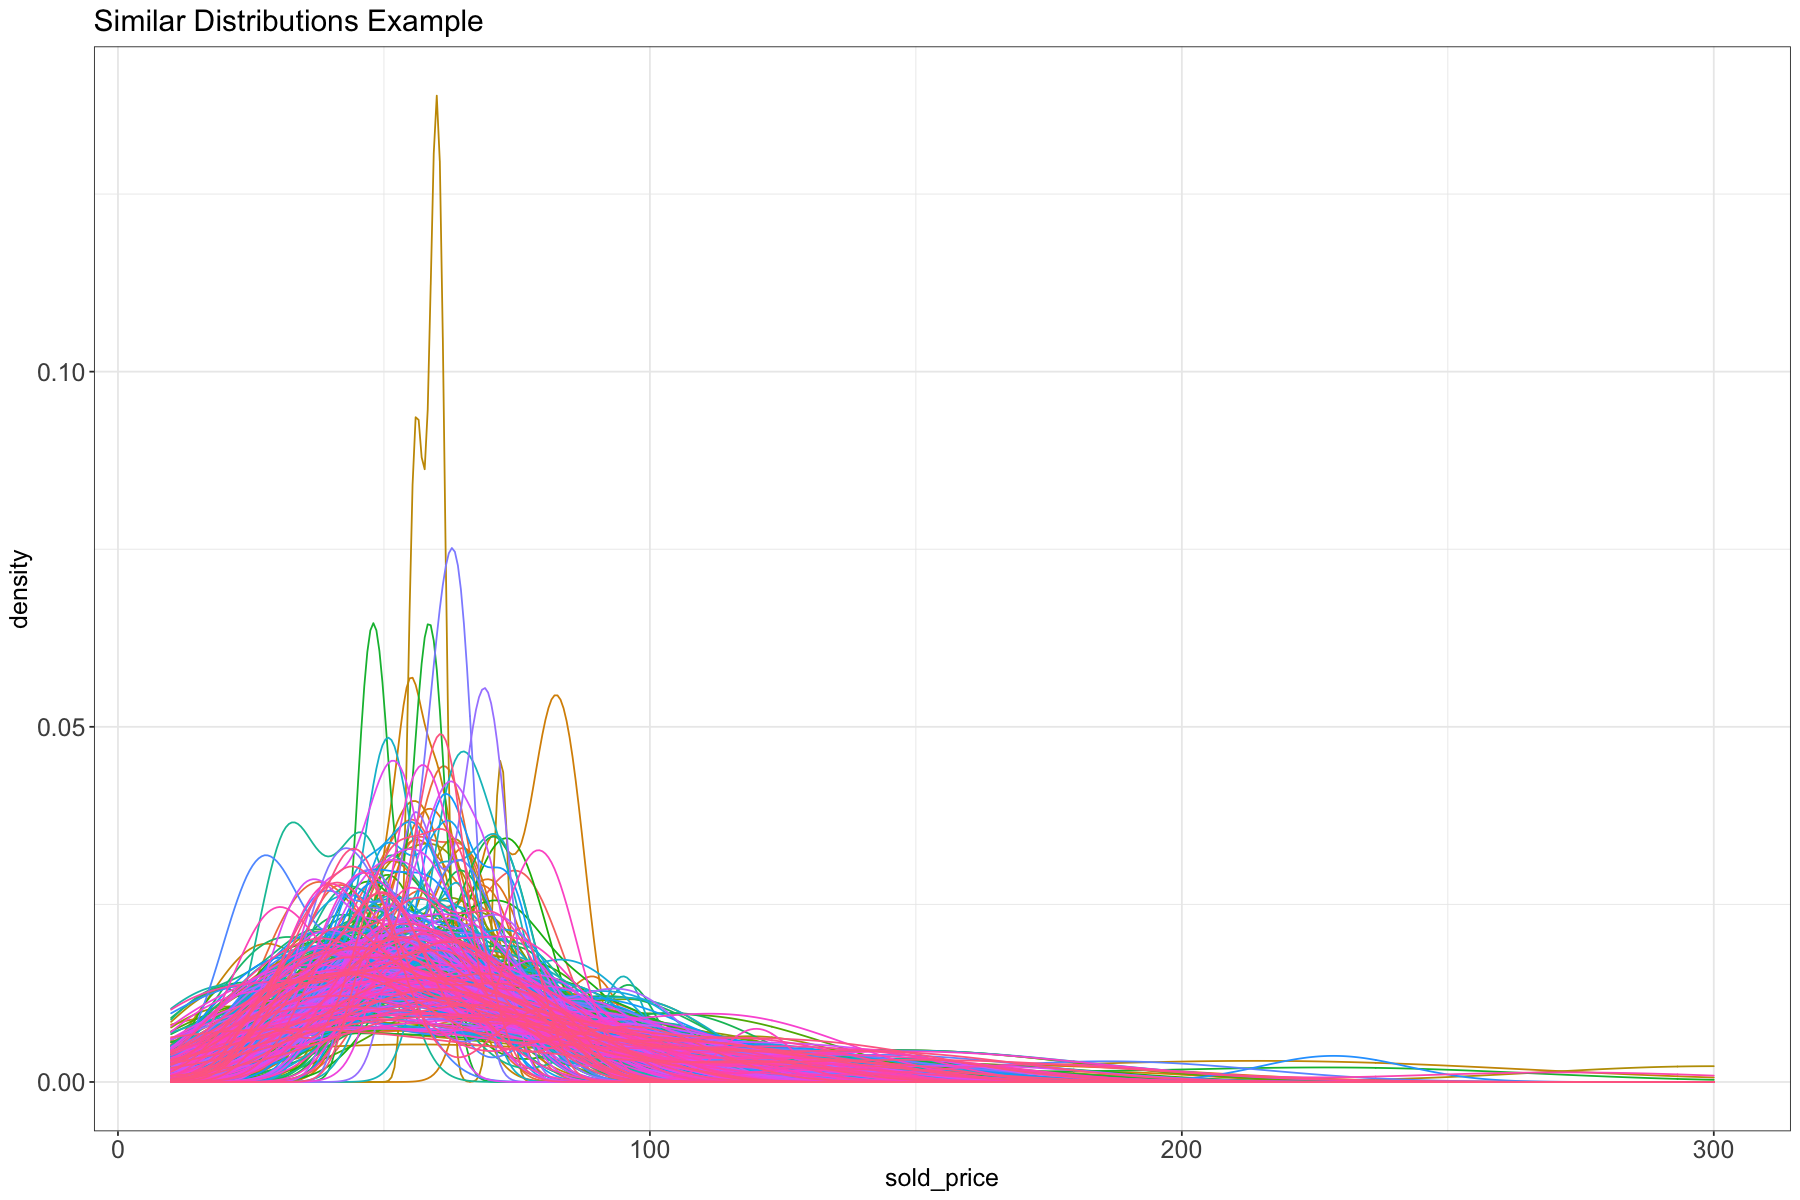

In [62]:
options(repr.plot.width=15, repr.plot.height=10)

a <- c('Cordless Drill',comb %>%
                         filter(ks >= 0.05) %>%
                         filter(grepl('dewalt-Cordless Drill',V1)) %>% select(V2) %>% pull)

data %>%
 filter(CategoryDesc %in% a) %>%
 ggplot() +
 geom_density(aes(sold_price, colour = CategoryDesc), alpha = 0.2) +
 theme_bw() +
 ggtitle('Similar Distributions Example') +
 theme(axis.text.x  = element_text(size = 15),
       axis.text.y  = element_text(size = 15),
       axis.title.x = element_text(size = 15),
       axis.title.y = element_text(size = 15),
       title        = element_text(size = 15),
       legend.position = 'none')

## Groups

Create groups using similar distributions

In [43]:
cats <- unique(c(comb$V1,comb$V2))


In [44]:
data.frame(CategoryDesc = NA,
           Group        = NA,
           Reference    = NA)  %>%
 filter(!is.na(NA)) -> groups


In [47]:
for(i in 1:length(cats)){    
    if(i == 1){
        
        aux1 <- comb %>% filter(V1 == cats[i],ks >= 0.05) %>% select(V2) %>% pull
        aux2 <- comb %>% filter(V2 == cats[i],ks >= 0.05) %>% select(V1) %>% pull
        g   <- c(cats[i], aux1, aux2)
        data.frame(CategoryDesc = g,
                   Group        = 1,
                   Reference    = cats[i]) -> df_aux
        
        } else {
        
        if(!(cats[i] %in% groups$CategoryDesc)){
            
            aux1 <- comb %>% filter(V1 == cats[i],ks >= 0.05) %>% select(V2) %>% pull
            aux2 <- comb %>% filter(V2 == cats[i],ks >= 0.05) %>% select(V1) %>% pull
            g   <- c(cats[i], aux1, aux2)
            last_group <- max(groups$Group)
            data.frame(CategoryDesc = g,
                       Group        = 1+last_group,
                       Reference    = cats[i]) -> df_aux
            
        }

    }
    
    groups <- rbind(groups,df_aux)
}

In [48]:
write.csv(groups,file = 'GroupsFirst_TimFilter_Jun20Dec20_20t.csv',row.names = FALSE)

In [63]:
#groups <- read_csv('/Users/darias/Documents/Bucket_Pricing/Data_Out/GroupsFirst_TimFilter_Jun20Dec20_20t.csv')

Parsed with column specification:
cols(
  CategoryDesc = col_character(),
  Group = col_double(),
  Reference = col_character()
)



In [64]:
groups %>%
 distinct -> groups

In [165]:
groups %>% head

CategoryDesc                            Group Reference             
1 snap-on-Cordless Drill                  1     snap-on-Cordless Drill
2 kicker-Car Woofer / Sub-Woofer Speakers 1     snap-on-Cordless Drill
3 apple-Smart Watches                     1     snap-on-Cordless Drill
4 hisense-Air Conditioner                 1     snap-on-Cordless Drill
5 husqvarna-Gas Leaf Blower               1     snap-on-Cordless Drill
6 stihl-Gas Leaf Blower                   1     snap-on-Cordless Drill

## Solve Ties

Assign Categories in more than one group, to the most similar group.

This will be done calculating the average KS p-value for each CategoryDesc in more than 1 group, versus all the CategoryDesc in each group, and it will be assigned in the group with the highest p-value average

In [166]:
groups %>%
 group_by(CategoryDesc) %>%
 tally %>%
 filter(n > 1) %>%
 arrange(desc(n)) %>%
 select(CategoryDesc) %>%
 pull -> reps

In [167]:
for(i in 1:length(reps)){
    options(warn=-1)
    
    # Get repeated Cat/Man
    cat_rep <- reps[i]
    
    # Get the category repeated KS test with all the other Cat/Man
    v1 <- comb %>% filter(V1 == cat_rep) %>% select(V2) %>% pull
    v2 <- comb %>% filter(V2 == cat_rep) %>% select(V1) %>% pull
    
    k1 <- comb %>% filter(V1 == cat_rep) %>% select(ks) %>% pull
    k2 <- comb %>% filter(V2 == cat_rep) %>% select(ks) %>% pull
    
    V <- c(v1,v2)
    K <- c(k1,k2)
    
    data.frame(CategoryDesc = as.character(V),
               ks           = K) -> df_aux
    
    # Add the group to each CatMan
    df_aux %>%
     left_join(groups %>% select(-Reference), by = 'CategoryDesc') -> df_aux
    
    # Get the group with highest KS p-value average
    df_aux %>%
     group_by(Group) %>%
     summarise(ks_avg = mean(ks, na.rm = TRUE)) %>%
     arrange(desc(ks_avg)) %>%
     head(1) %>%
     select(Group) -> opt_cluster

    groups %>%
     filter(CategoryDesc != cat_rep) -> groups
    
    groups %>%
     filter(Group == opt_cluster %>% pull) %>%
     select(Reference) %>%
     head(1) -> Ref
    
    data.frame(CategoryDesc = cat_rep,
               Group        = opt_cluster,
               Reference    = Ref) -> df_aux2
    
    groups <- rbind(groups, df_aux2) %>% arrange(Group)
}

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `

In [62]:
#for(i in 1:length(reps)){
#    options(warn=-1)
#    cat_rep <- reps[i]
#    
#    data.frame(cluster = NA,
#               avg_ks  = NA) %>%
#     filter(!is.na(cluster)) -> df
#    
#    for(j in 1:num_groups){
#        categ     <- groups %>% filter(Group == j) %>% select(CategoryDesc) %>% pull
#        num_categ <- length(categ)
#        
#        kss <- NA
#        for(k in 1:num_categ){
#            dist1 <- data %>% filter(CategoryDesc == categ[k]) %>% select(sold_price) %>% pull
#            dist2 <- data %>% filter(CategoryDesc == cat_rep) %>% select(sold_price) %>% pull
#            
#            ks_p <- ks.test(dist1,dist2)
#            
#            kss <- c(kss,ks_p$p.value)
#        }
#        
#        data.frame(cluster = j,
#                   avg_ks  = mean(kss,na.rm = TRUE)) -> aux
#        
#        df <- rbind(df,aux)
#    }
#    
#    
#    df %>%
#     arrange(desc(avg_ks)) %>%
#     head(1) %>%
#     select(cluster) %>%
#     pull -> opt_cluster
#    
#    groups %>%
#     filter(CategoryDesc != cat_rep) -> groups
#    
#    groups %>%
#     filter(Group == opt_cluster) %>%
#     select(Reference) %>%
#     head(1) -> Ref
#    
#    data.frame(CategoryDesc = cat_rep,
#               Group        = opt_cluster,
#               Reference    = Ref) -> aux2
#    
#    groups <- rbind(groups, aux2) %>% arrange(Group)
#    
#}

In [171]:
setwd('/Users/darias/Documents/Bucket_Pricing/Data_Out/')
write.csv(groups,file = 'groups_ManufacturerKS_TimFilters_Jun20Dec20_20t.csv',row.names = FALSE)


In [66]:
#groups <- read_csv('/Users/darias/Documents/Bucket_Pricing/Data_Out/groups_ManufacturerKS_TimFilters_Jun20Dec20_20t.csv')

Parsed with column specification:
cols(
  CategoryDesc = col_character(),
  Group = col_double(),
  Reference = col_character()
)



Add the groups in all the data

In [67]:
data %>%
 left_join(groups, by = 'CategoryDesc') -> data


In [68]:
length(unique(groups$Group))


[1] 111

## Example similar Distributions

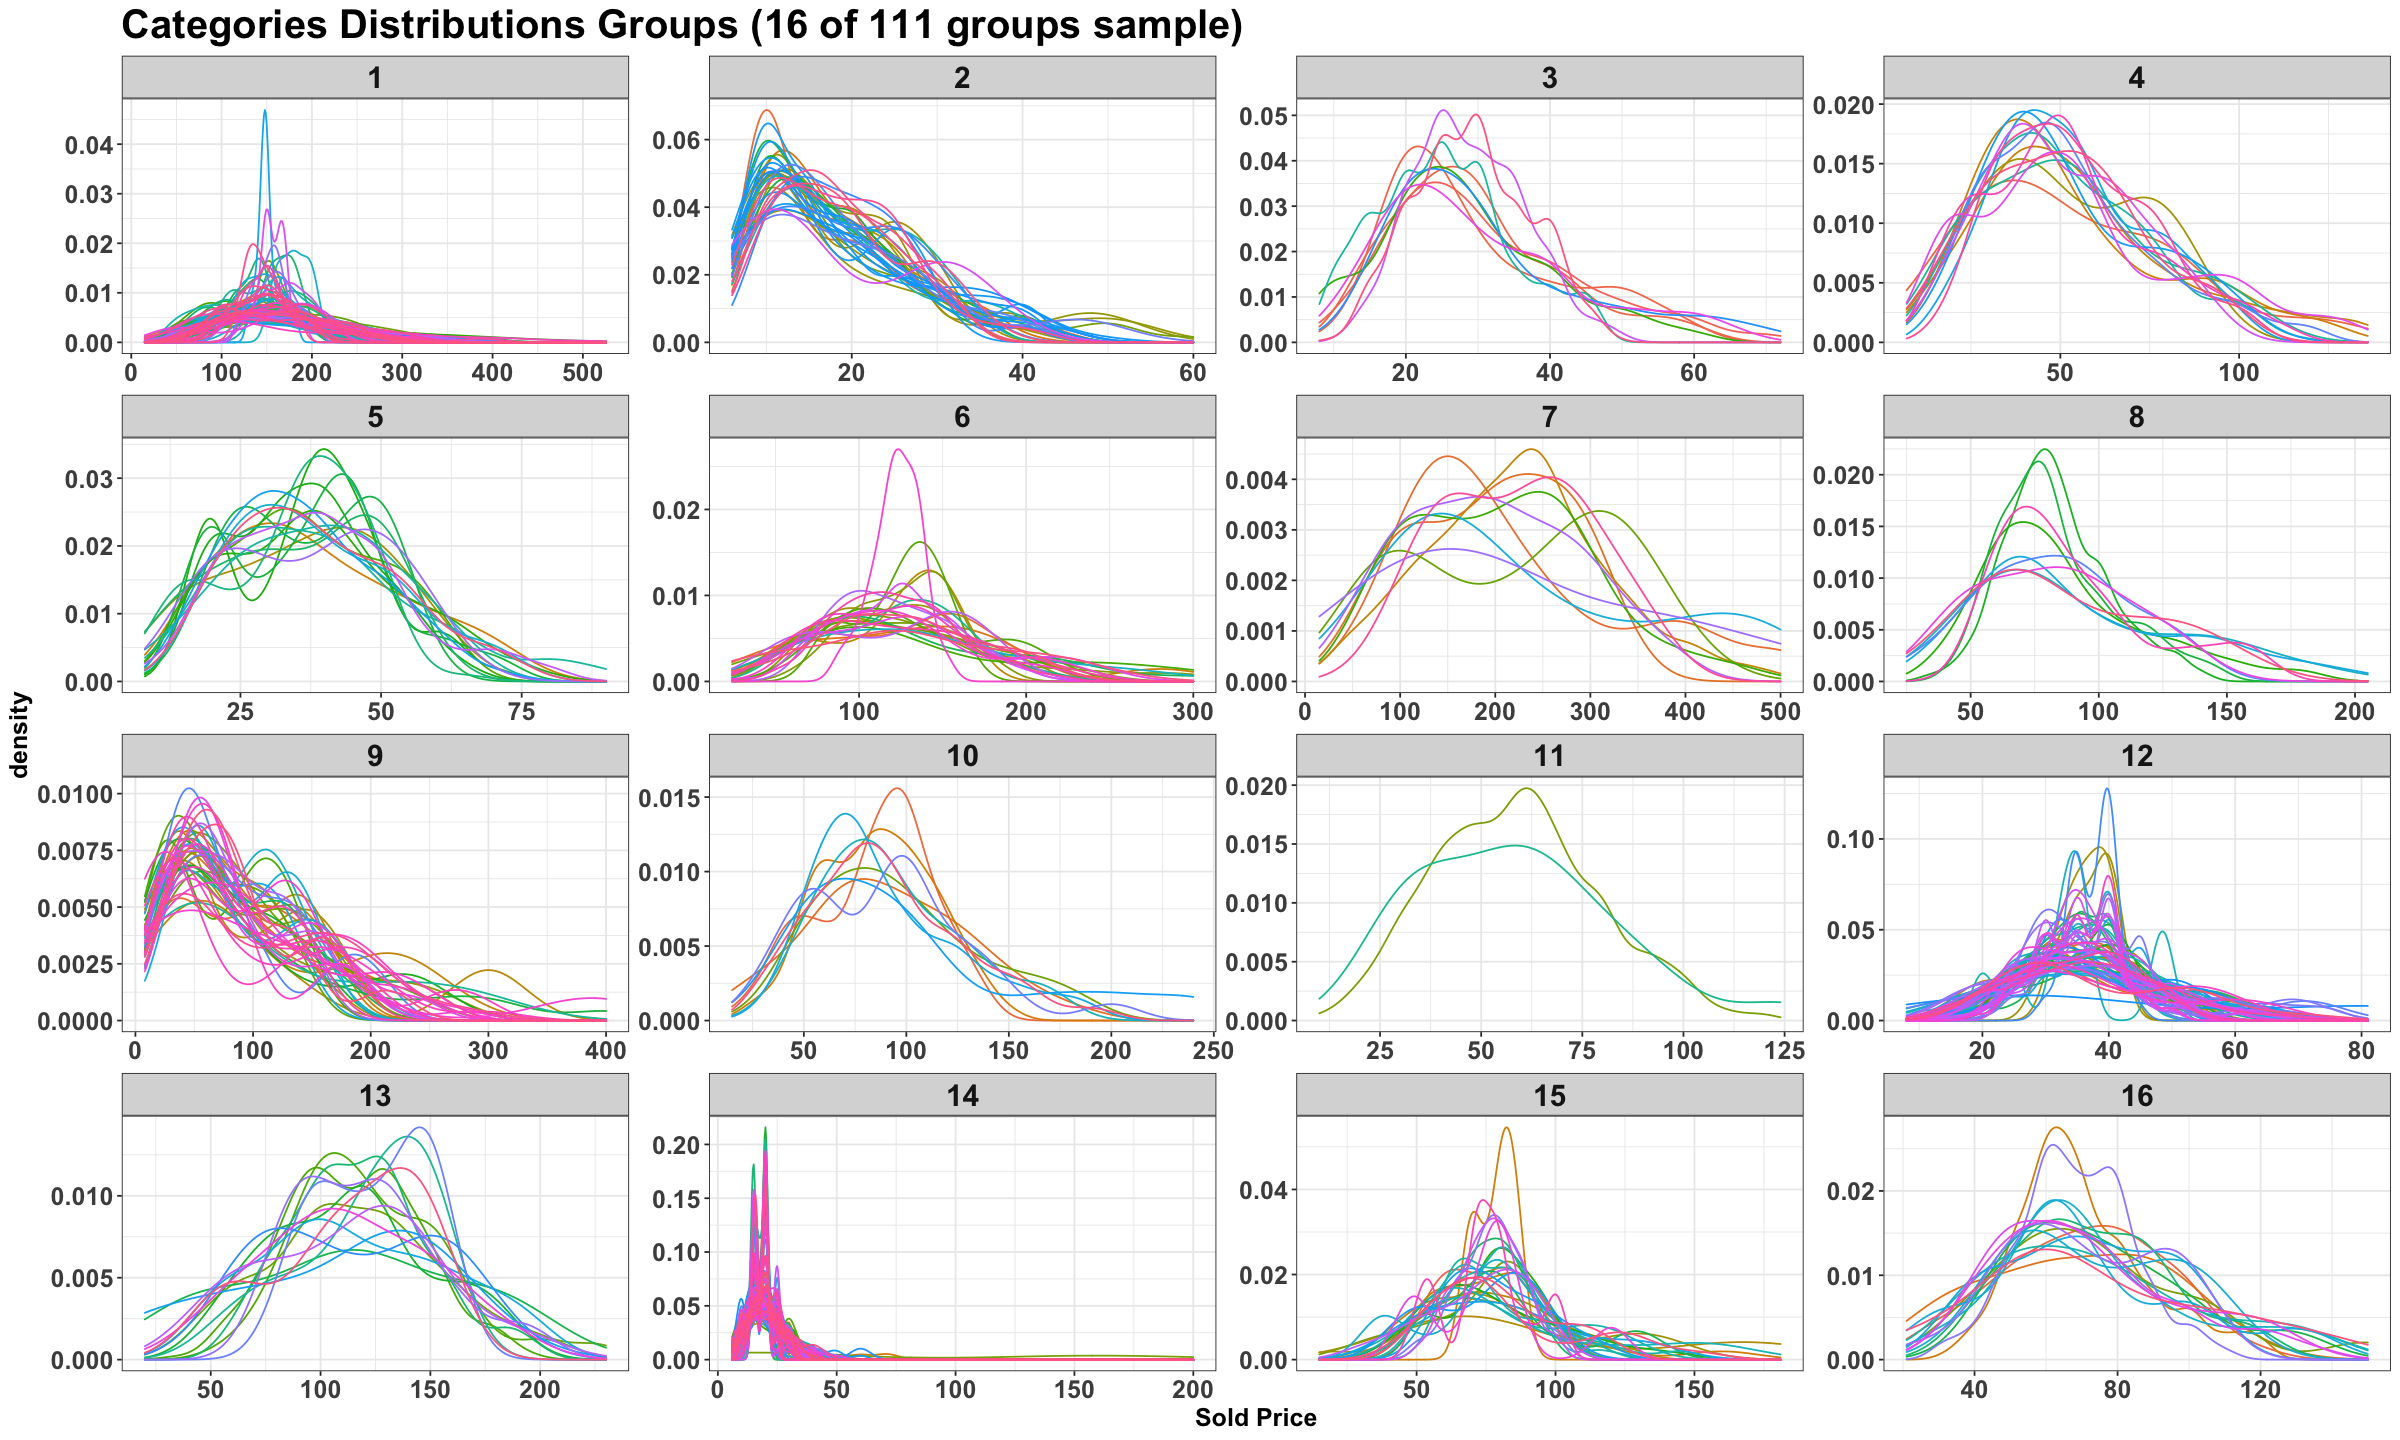

In [69]:
options(repr.plot.width=20, repr.plot.height=12)

data %>%
 filter(Group <= 16) %>%
 ggplot() +
 geom_density(aes(sold_price, colour = CategoryDesc)) +
 theme_bw() +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       legend.position = 'none',
       strip.text.x    = element_text(size = 18, face = 'bold')) +
 facet_wrap(~Group, scales = 'free') +
 ggtitle('Categories Distributions Groups (16 of 111 groups sample)') +
 xlab('Sold Price')
 

# Write data

Write item level data, with the group

In [175]:
getwd()


[1] "/Users/darias/Documents/Bucket_Pricing/Data_Out"

In [176]:
setwd('/Users/darias/Documents/Bucket_Pricing/Data_Out/')
write.csv(data %>% select(-Reference), file = 'Item_Groups_Distribution_Manufacturer_TimFilters_Jun20Dec20_20t.csv', row.names = FALSE)


In [32]:
#data <- read_csv('/Users/darias/Documents/Bucket_Pricing/Data_Out/Item_Groups_Distribution_Manufacturer_TimFilters.csv')

Parsed with column specification:
cols(
  .default = col_character(),
  primary_relation = col_double(),
  FiscalYear = col_double(),
  original_price = col_double(),
  sold_price = col_double(),
  tax = col_double(),
  ItemID = col_double(),
  cost = col_double(),
  item_categorization = col_double(),
  Inventory_Days = col_double(),
  date = col_date(format = ""),
  LTV = col_double(),
  Group = col_double()
)

See spec(...) for full column specifications.



In [177]:
tail(groups)


CategoryDesc                Group Reference              
1 craftsman-Riding Lawnmower  111   hohner-Button Accordion
2 makita-Jackhammers          111   hohner-Button Accordion
3 husqvarna-Gas Cutoff Saw    111   hohner-Button Accordion
4 husqvarna-Gas Concrete Saws 111   hohner-Button Accordion
5 stihl-Gas Cutoff Saw        111   hohner-Button Accordion
6 stihl-Gas Concrete Saws     111   hohner-Button Accordion

# Buckets

The buckets will be calculated as the **mode** of the **Group distributions**.

Not will be considered all the **Groups** for this analysis, onlye those with this characteristics:
 - Distributions with significant modes: Distributions with modes with at least 20% of the cases
  -  With kow variance/Not too flat: Groups with Skewness >= 0.5
 - Multimode: Distributions with more than 1 mode

## Calculate modes

In [75]:
data %>%
 mutate(sold_price = round(sold_price)) %>%
 group_by(Group,sold_price) %>%
 summarise(n = n()) %>%
 ungroup %>%
 group_by(Group) %>%
 mutate(total = sum(n)) %>%
 ungroup %>%
 mutate(pct = n/total) %>%
 filter(pct >= 0.2) %>%
 group_by(Group) %>%
 mutate(mode_ind = dense_rank(-pct),
        mode_ind = paste0('mode',mode_ind)) %>%
 rename('mode' = 'sold_price') %>%
 select(Group,mode,mode_ind) %>%
 group_by(Group) %>%
 mutate(num_modes = n()) %>%
 group_by(Group) %>%
 mutate(num_modes = max(num_modes)) -> modes

head(modes,4)


`summarise()` regrouping output by 'Group' (override with `.groups` argument)



Group mode mode_ind num_modes
1  2    10   mode1    1        
2 12    40   mode1    1        
3 14    20   mode1    1        
4 17    25   mode2    2

## Calculate Skewness

In [76]:
skewness=function(x) {
m3=mean((x-mean(x))^3)
skew=m3/(sd(x)^3)
skew}


In [77]:
data %>%
 group_by(Group) %>%
 summarise(sk = skewness(sold_price)) -> sk_df


`summarise()` ungrouping output (override with `.groups` argument)



## Get buckets

With these rules:
 - If it is multimode, the buckets will be the modes
 - If it not multimode, and has skewness >= 0.5, and has a significant mode (>= 20%), then the bucket will be the mode

In [78]:
sk_df %>%
 left_join(modes,by='Group') %>%
 filter((num_modes==1 | sk >= 0.05) | num_modes > 1) %>%
 filter(!is.na(mode)) -> groups_buckets


Add the Manufacturer for the Groups

In [85]:
data %>%
 distinct(Group, CategoryDesc, CategoryDesc_original,Manufacturer) -> CD

groups_buckets %>%
 left_join(CD,by='Group') %>%
 select(-sk) -> Manufacturer_Buckets


Write Data

In [88]:
setwd('/Users/darias/Documents/Bucket_Pricing/Data_Out/')
write.csv(Manufacturer_Buckets, file = 'Buckets_Manufacturer_TimFilters_Jun20Dec20_20t.csv', row.names = FALSE)

In [81]:
#Manufacturer_Buckets<-read_csv('/Users/darias/Documents/Bucket_Pricing/Data_Out/Buckets_Manufacturer_TimFilters_Jun20Dec20_20t.csv')

Parsed with column specification:
cols(
  Group = col_double(),
  mode = col_double(),
  mode_ind = col_character(),
  num_modes = col_double(),
  CategoryDesc = col_character()
)



In [186]:
unique(data$CategoryDesc) %>% length


[1] 2887

In [187]:
unique(Manufacturer_Buckets$CategoryDesc) %>% length


[1] 1000

# Examples

## No Bucket example

In [191]:
unique(Manufacturer_Buckets$Group)


[1]   2  12  14  17  32  33  41  44  52  59  63  67  73  74  81 101 108 109 110

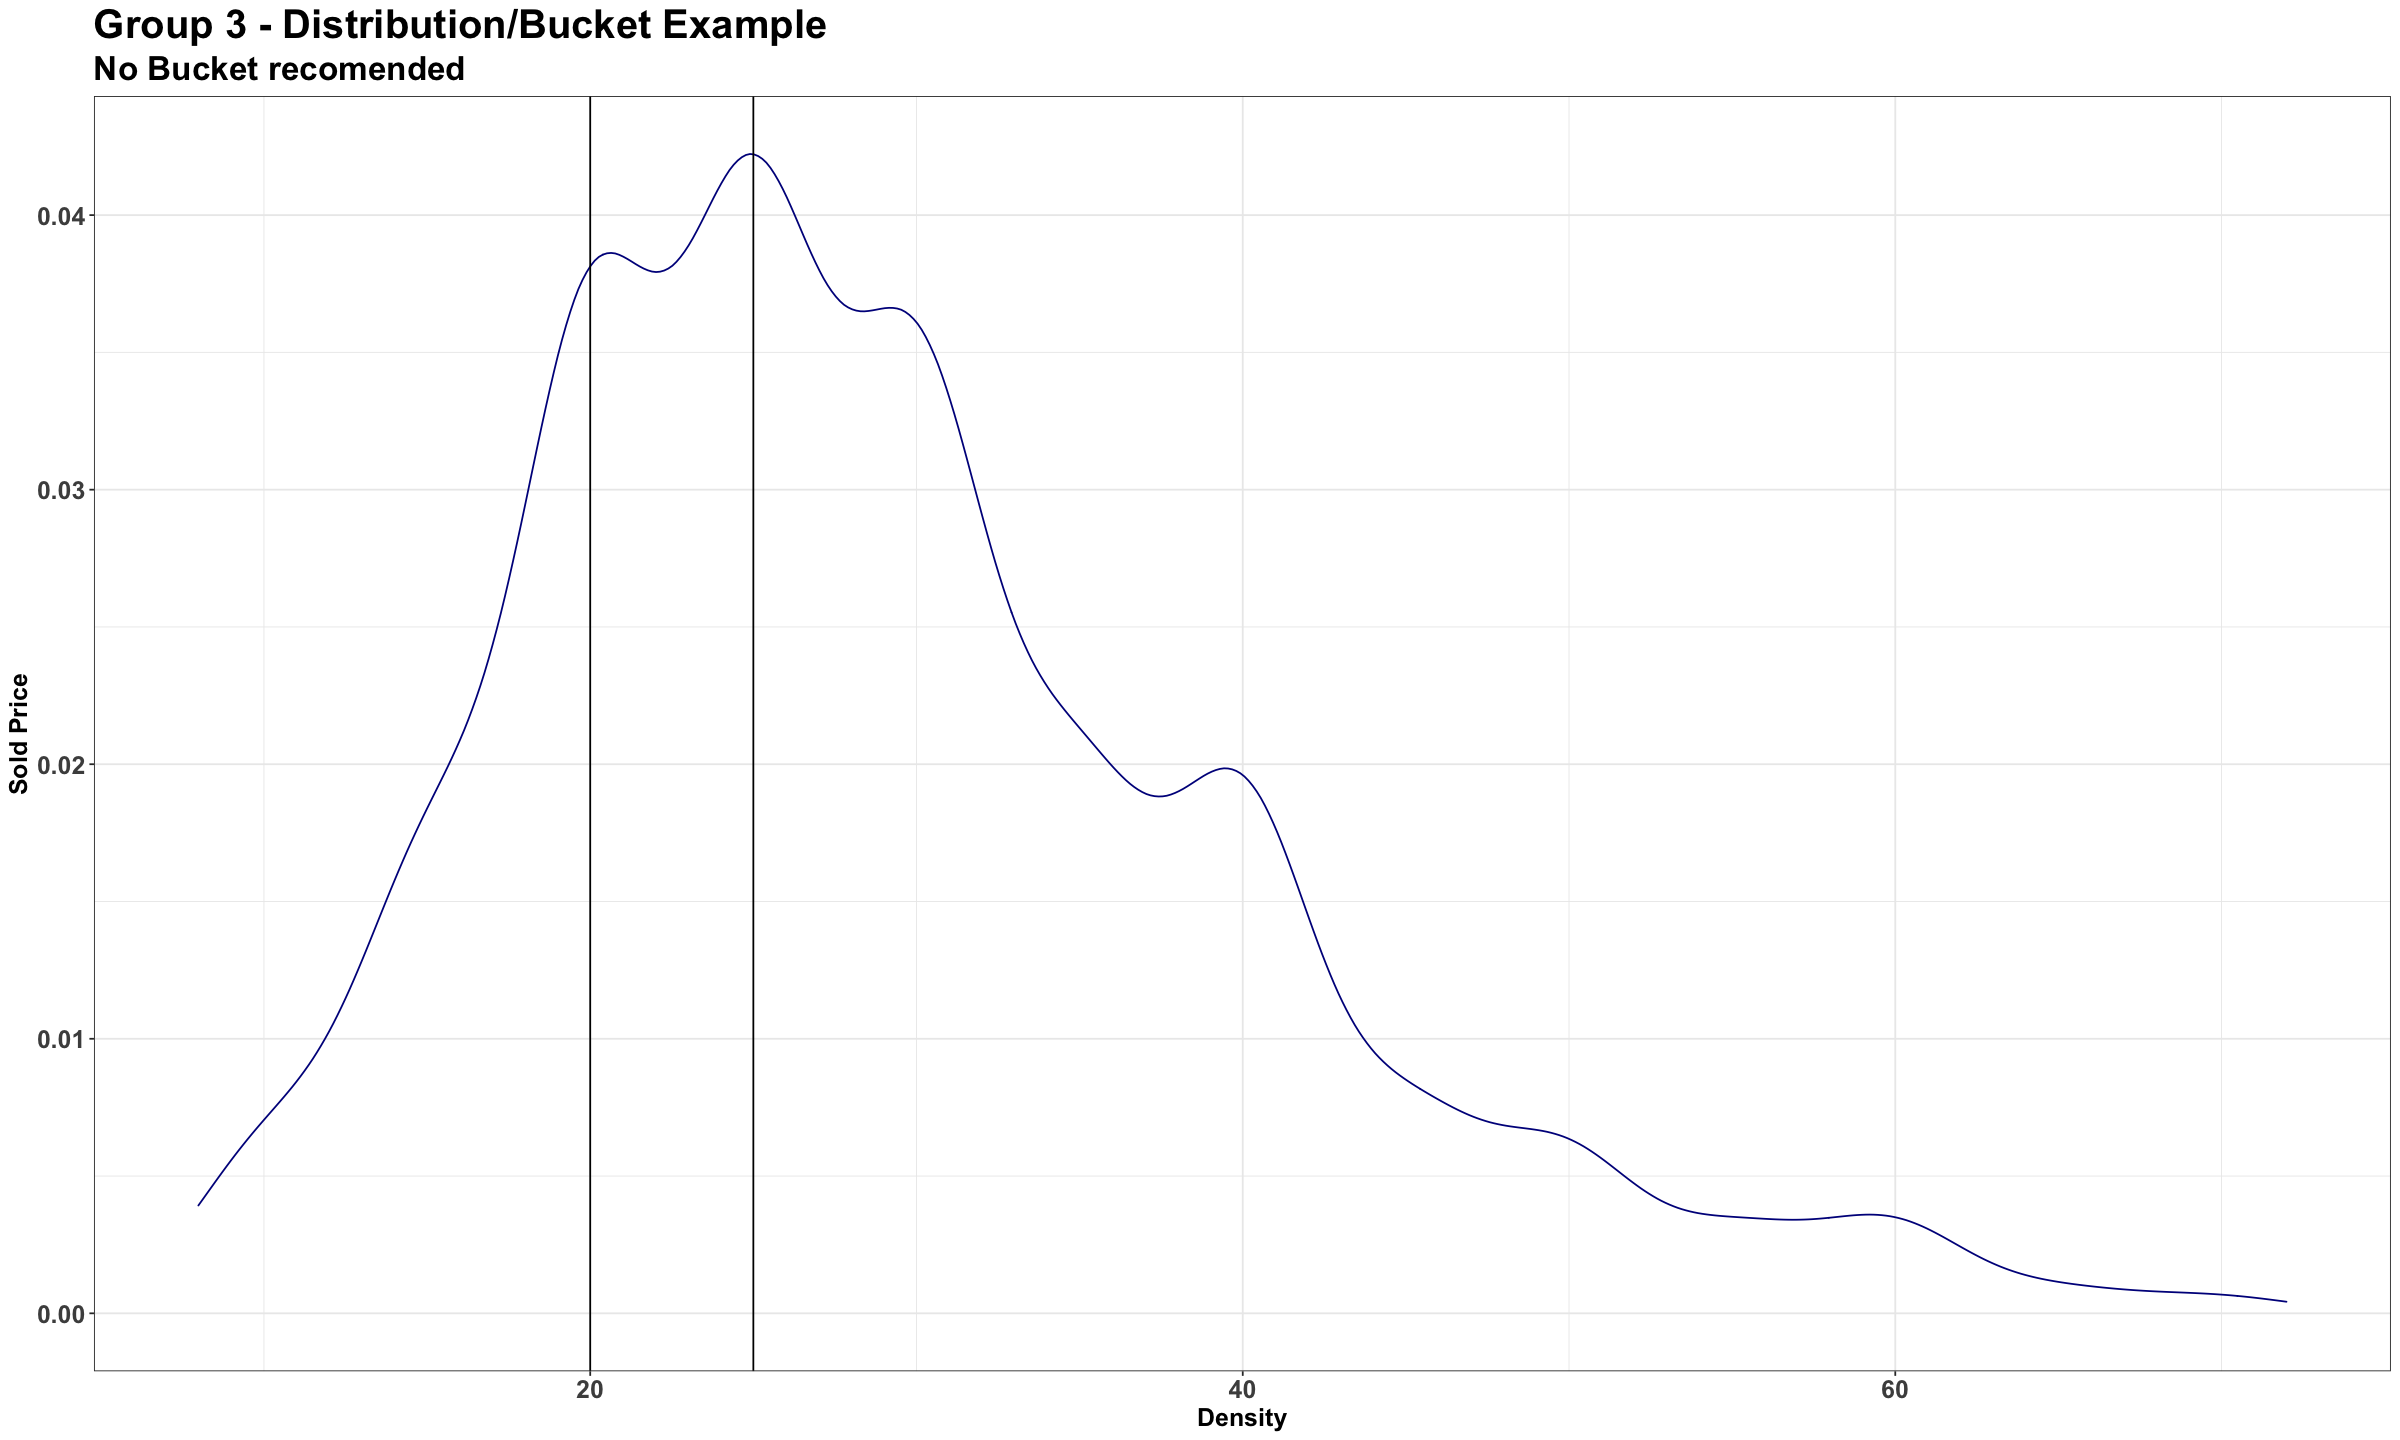

In [194]:
data %>%
 mutate(sold_price = round(sold_price)) %>%
 filter(Group == 3) %>%
 group_by(sold_price) %>%
 tally %>%
 arrange(desc(n)) %>%
 mutate(rank = dense_rank(-n)) -> a

a %>%
 filter(rank == 1) %>%
 select(sold_price) %>%
 pull -> m1

a %>%
 filter(rank == 2) %>%
 select(sold_price) %>%
 pull -> m2

data %>%
 filter(Group == 3) %>%
 ggplot() +
 geom_density(aes(sold_price), colour = 'darkblue') +
 ggtitle('Group 3 - Distribution/Bucket Example', subtitle = 'No Bucket recomended') +
 theme_bw() +
 ylab('Sold Price') +
 xlab('Density') +
 geom_vline(xintercept = m1) +
 geom_vline(xintercept = m2) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

## One Bucket Example

In [204]:
Manufacturer_Buckets %>%
 filter(num_modes == 1) %>%
 distinct(Group) %>%
 head(10)

Group
1    2  
2   12  
3   14  
4   32  
5   33  
6   52  
7   63  
8   74  
9  108  
10 109

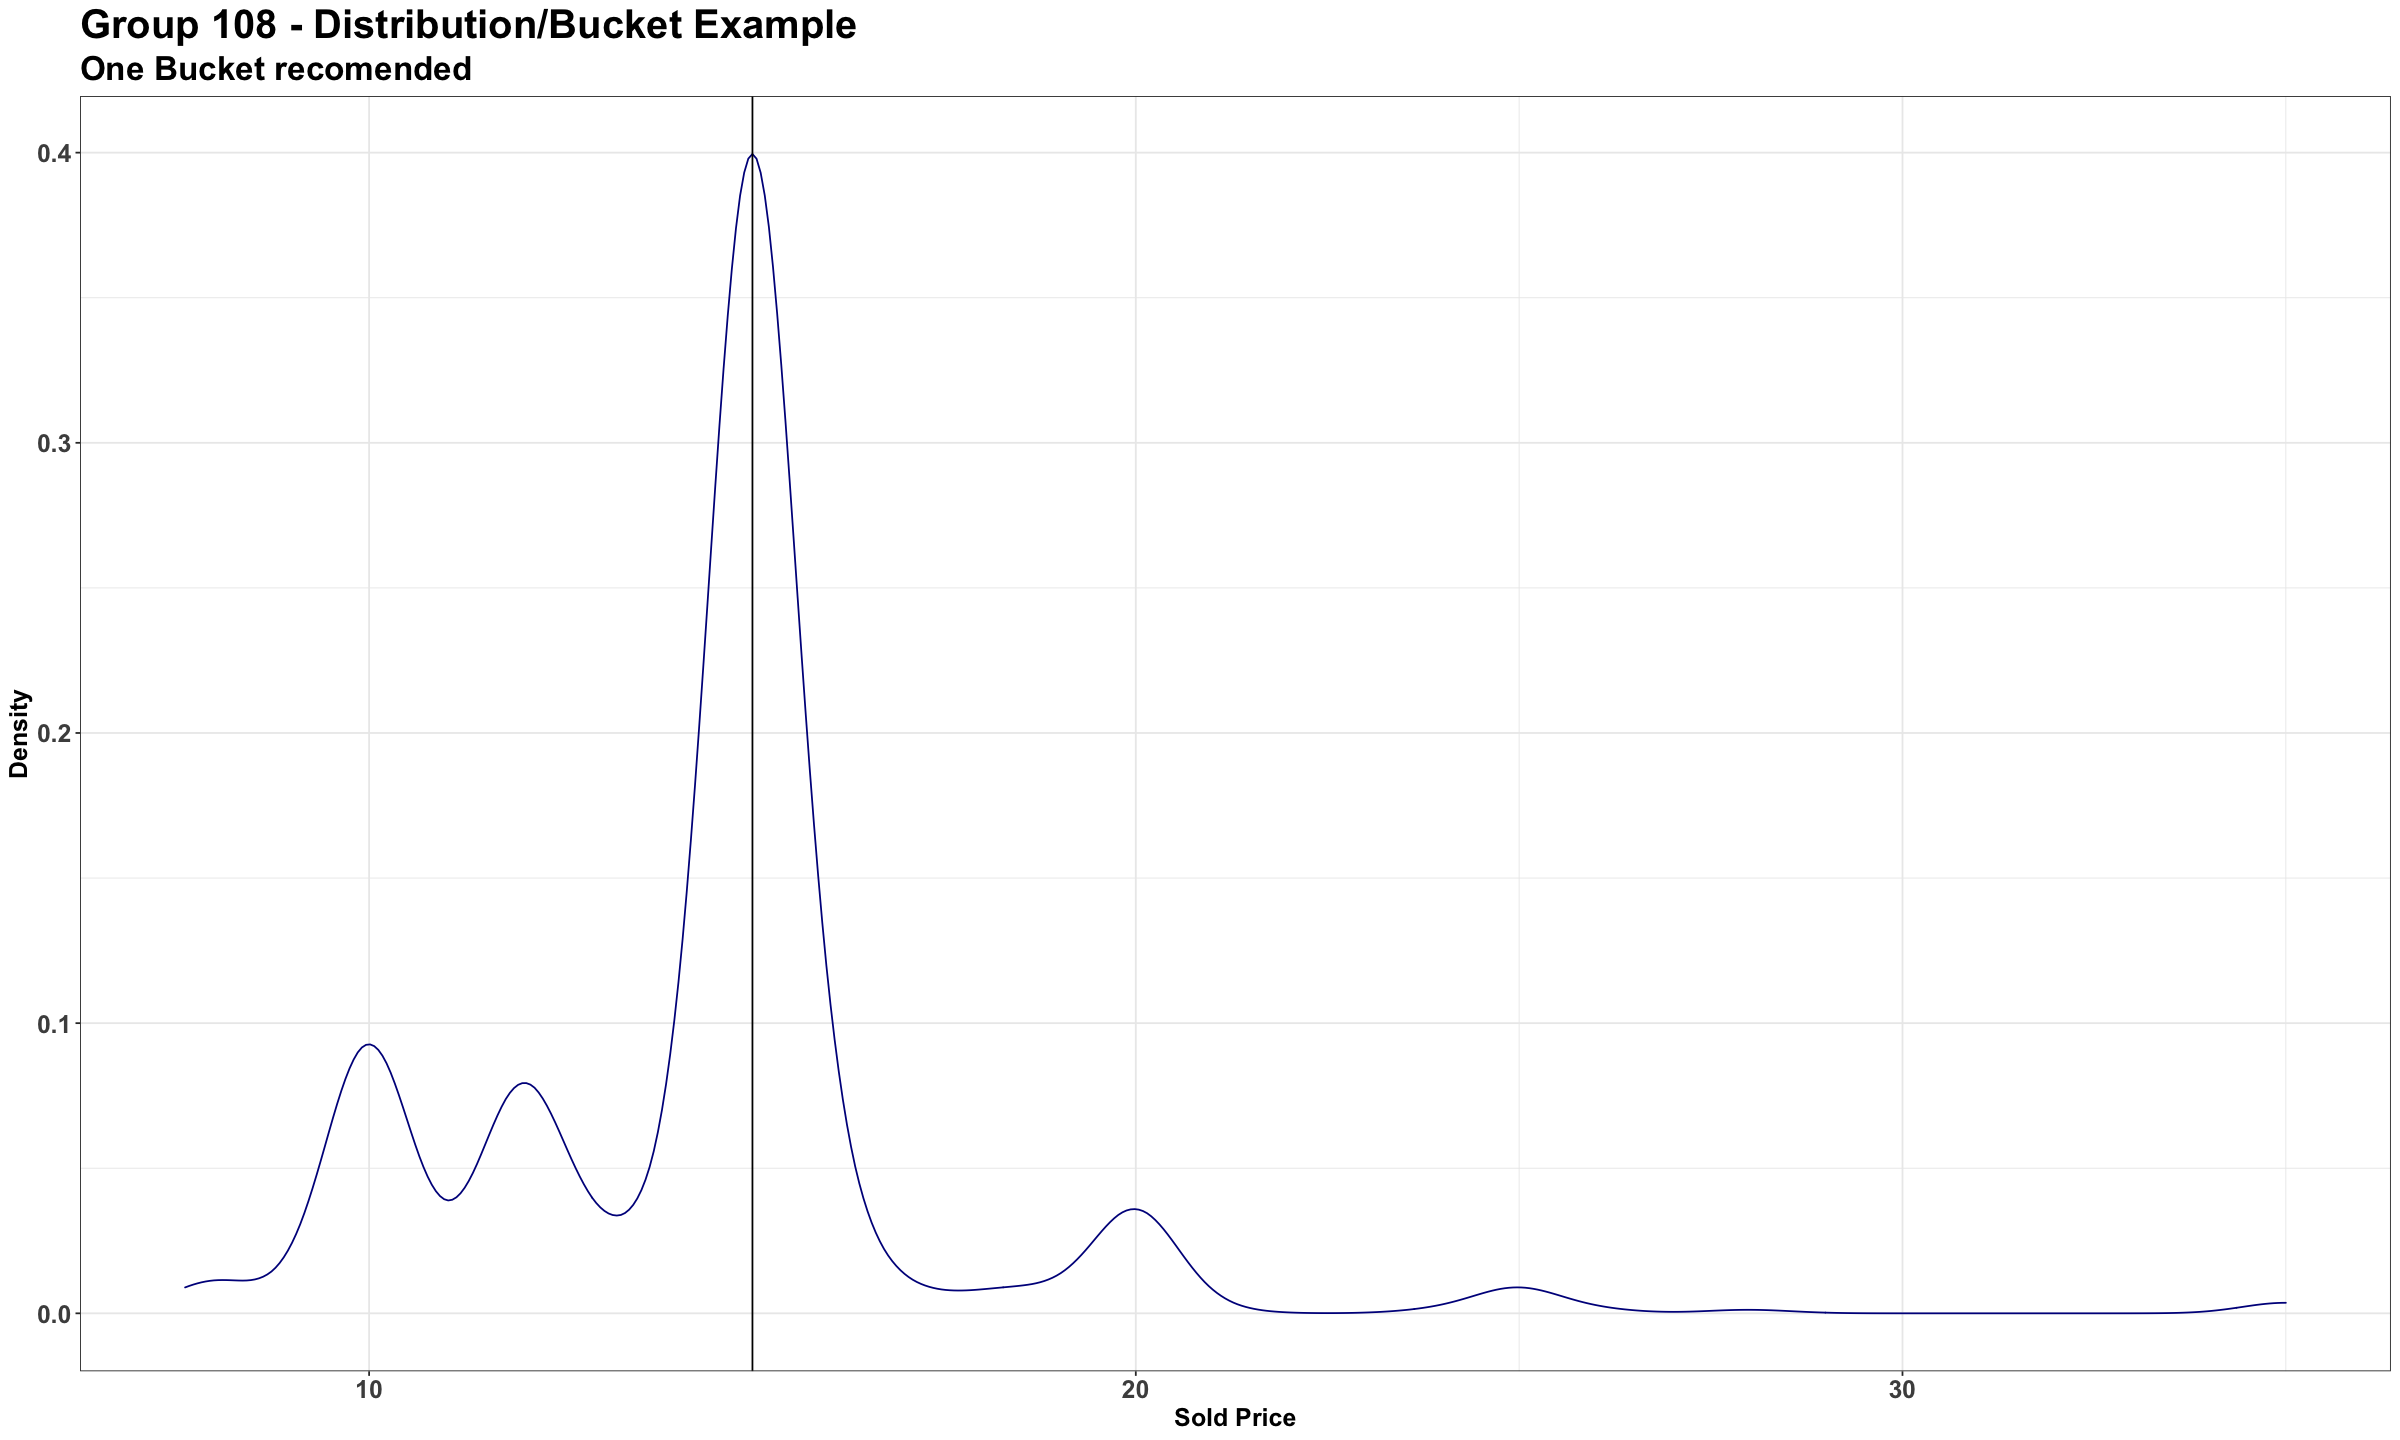

In [207]:
data %>%
 mutate(sold_price = round(sold_price)) %>%
 filter(Group == 108) %>%
 group_by(sold_price) %>%
 tally %>%
 arrange(desc(n)) %>%
 mutate(rank = dense_rank(-n)) -> a

a %>%
 filter(rank == 1) %>%
 select(sold_price) %>%
 pull -> m1

data %>%
 filter(Group == 108) %>%
 ggplot() +
 geom_density(aes(sold_price), colour = 'darkblue') +
 ggtitle('Group 108 - Distribution/Bucket Example', subtitle = 'One Bucket recomended') +
 theme_bw() +
 xlab('Sold Price') +
 ylab('Density') +
 geom_vline(xintercept = m1) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

## Two Bucket Example

In [209]:
Manufacturer_Buckets %>%
 filter(num_modes == 2) %>%
 distinct(Group) %>%
 head(10)

Group
1  17  
2  41  
3  44  
4  59  
5  67  
6  73  
7  81  
8 101

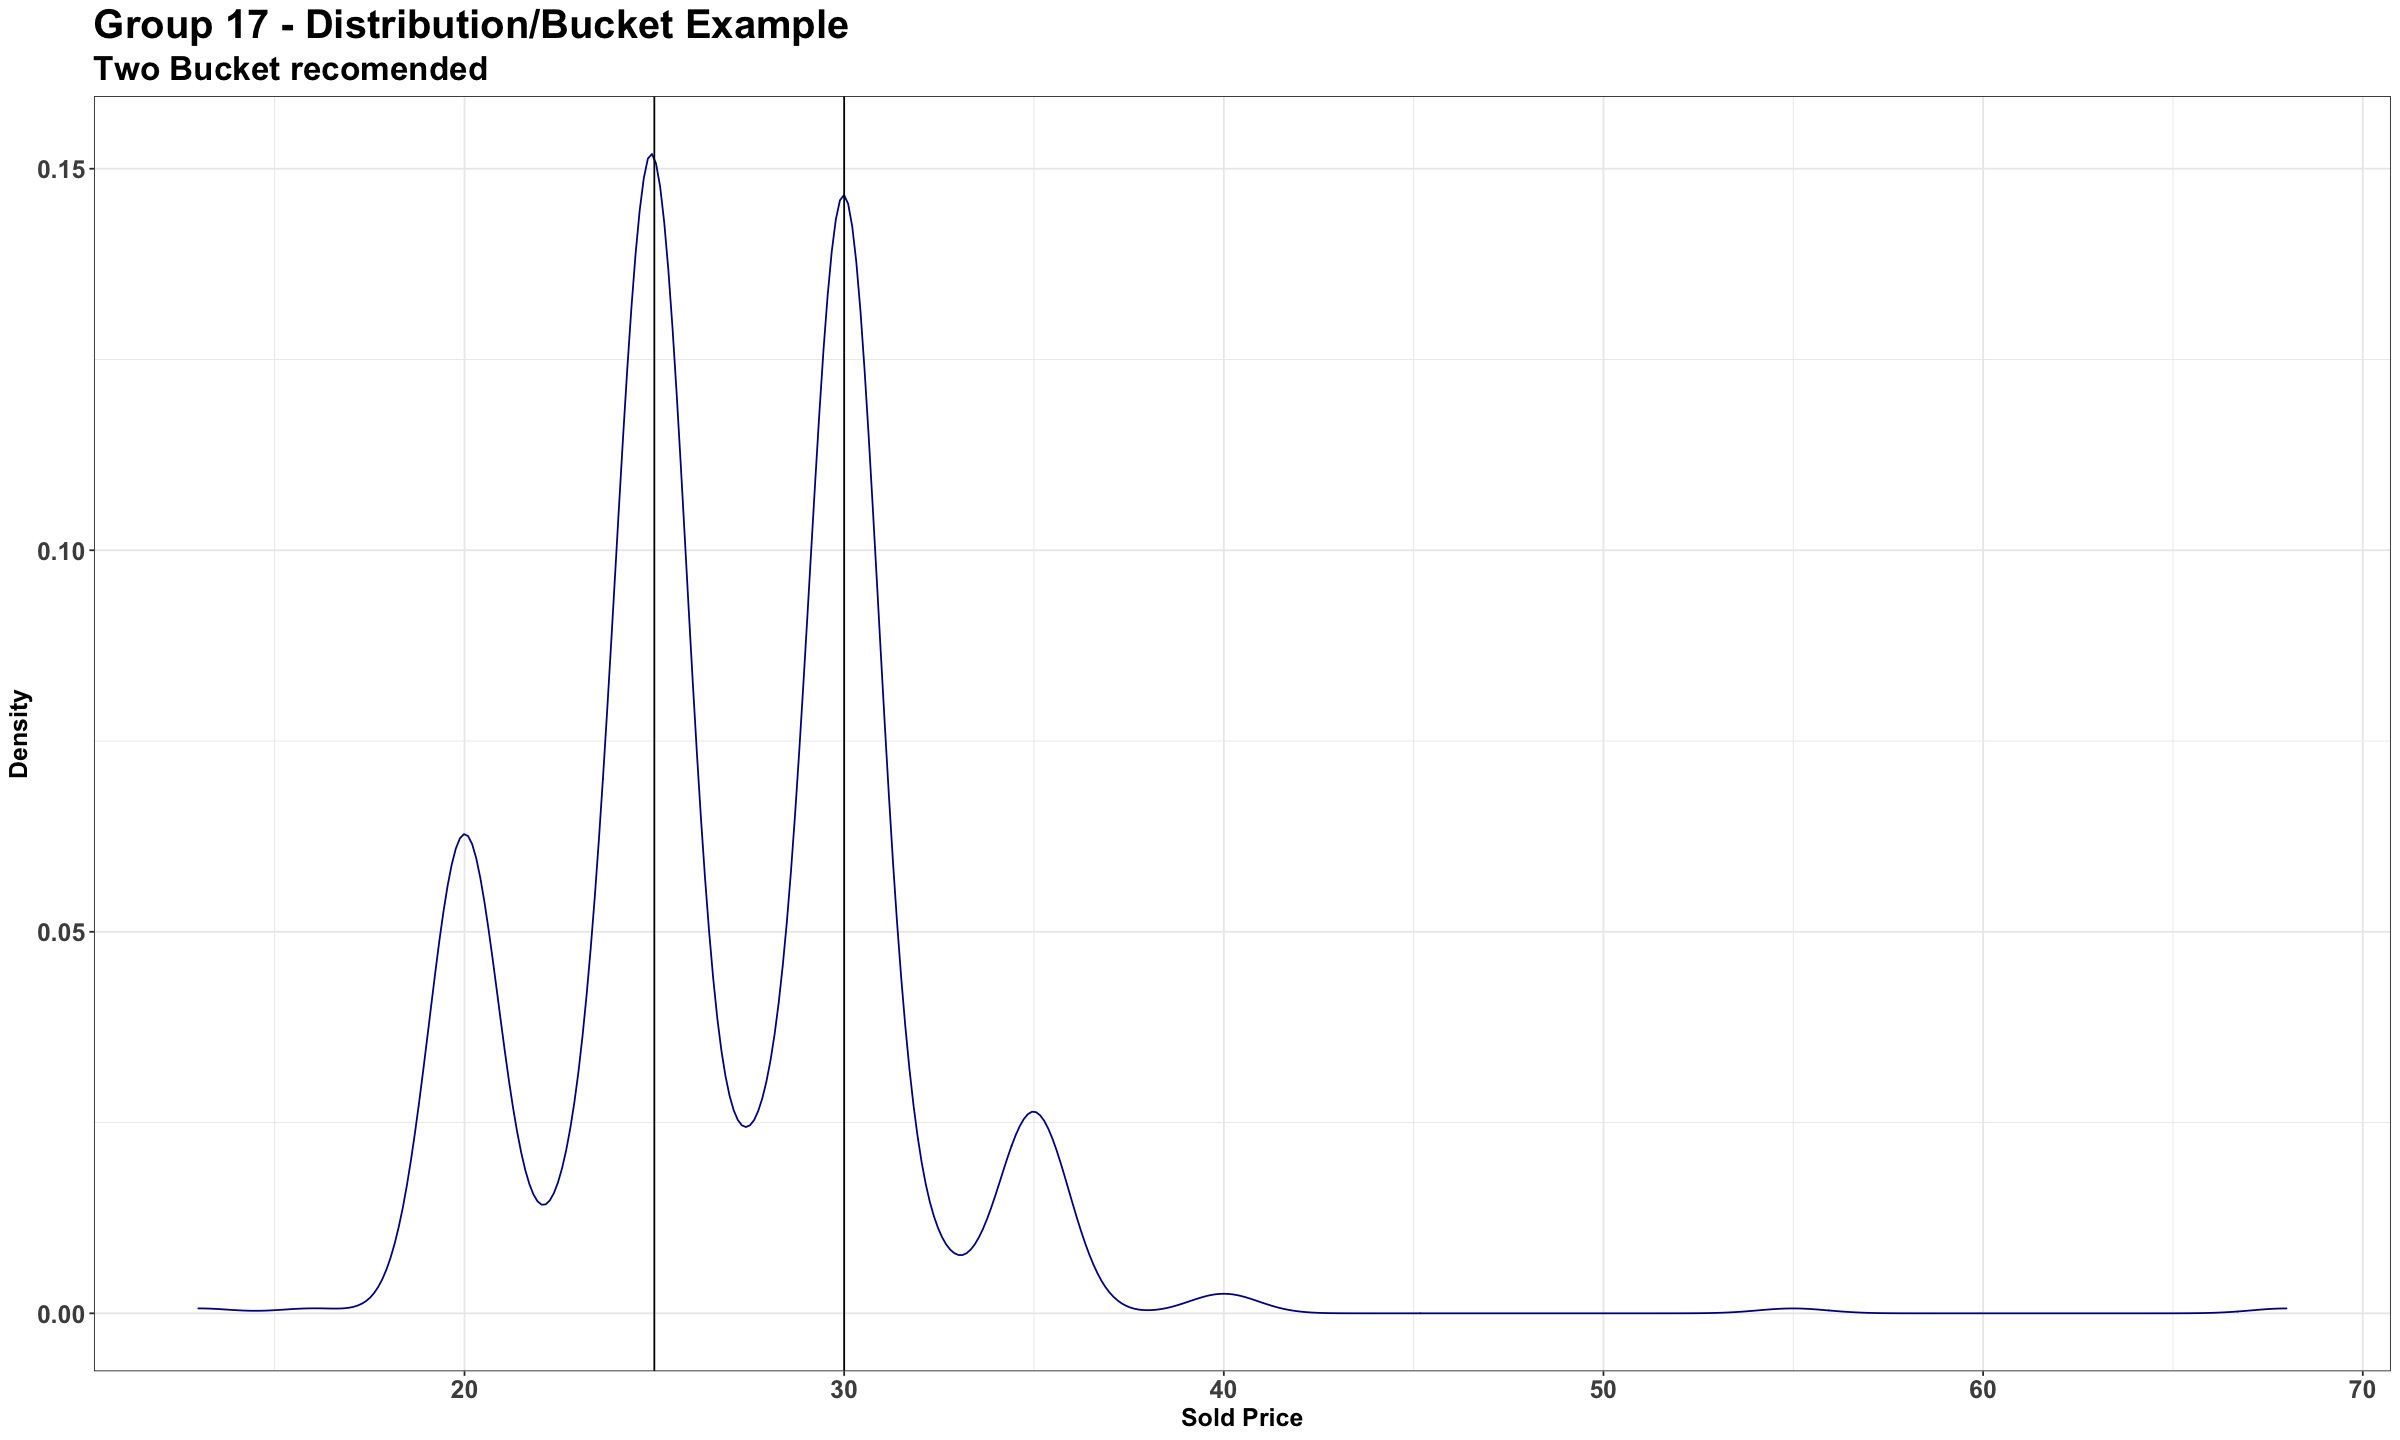

In [212]:
data %>%
 mutate(sold_price = round(sold_price)) %>%
 filter(Group == 17) %>%
 group_by(sold_price) %>%
 tally %>%
 arrange(desc(n)) %>%
 mutate(rank = dense_rank(-n)) -> a

a %>%
 filter(rank == 1) %>%
 select(sold_price) %>%
 pull -> m1

a %>%
 filter(rank == 2) %>%
 select(sold_price) %>%
 pull -> m2


data %>%
 filter(Group == 17) %>%
 ggplot() +
 geom_density(aes(sold_price), colour = 'darkblue') +
 ggtitle('Group 17 - Distribution/Bucket Example', subtitle = 'Two Bucket recomended') +
 theme_bw() +
 xlab('Sold Price') +
 ylab('Density') +
 geom_vline(xintercept = m1) +
 geom_vline(xintercept = m2) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))



# Business Case - Sold Price

We will see the total sold amount of the Manufacturers with a bucket, using the real sold price and the one in the bucket

In [213]:
Manufacturer_Buckets %>%
 group_by(CategoryDesc) %>%
 summarise(bucket = mean(mode)) -> buc


`summarise()` ungrouping output (override with `.groups` argument)



In [214]:
data %>%
 filter(CategoryDesc %in% Manufacturer_Buckets$CategoryDesc) %>%
 left_join(buc, by = 'CategoryDesc') -> data_buc


In [215]:
real      <- sum(data_buc$sold_price)
estimated <- sum(data_buc$bucket)

print(paste0('The real amount earned for items with Manufacturers with bucket assigned is: $', scales::comma(round(real))))
print(paste0('The estimated amount earned for items with Manufacturers with bucket assigned is: $', scales::comma(round(estimated))))

[1] "The real amount earned for items with Manufacturers with bucket assigned is: $1,404,312"
[1] "The estimated amount earned for items with Manufacturers with bucket assigned is: $1,374,765"


Annualize numbers:

We know that the numbers above are from July2020 - Nov2020 (7 months).

If we suppose is a uniform distribution of earnings, we can multiply those numbers by 12/7

In [219]:
real_anual <- real*(12/7)
estimated_anual <- estimated*(12/7)

print(paste0('The real amount, anualized, earned for items with Manufacturers with bucket assigned is: $', scales::comma(round(real_anual))))
print(paste0('The estimated amount, anualized, earned for items with Manufacturers with bucket assigned is: $', scales::comma(round(estimated_anual))))

[1] "The real amount, anualized, earned for items with Manufacturers with bucket assigned is: $2,407,392"
[1] "The estimated amount, anualized, earned for items with Manufacturers with bucket assigned is: $2,356,740"


Plots

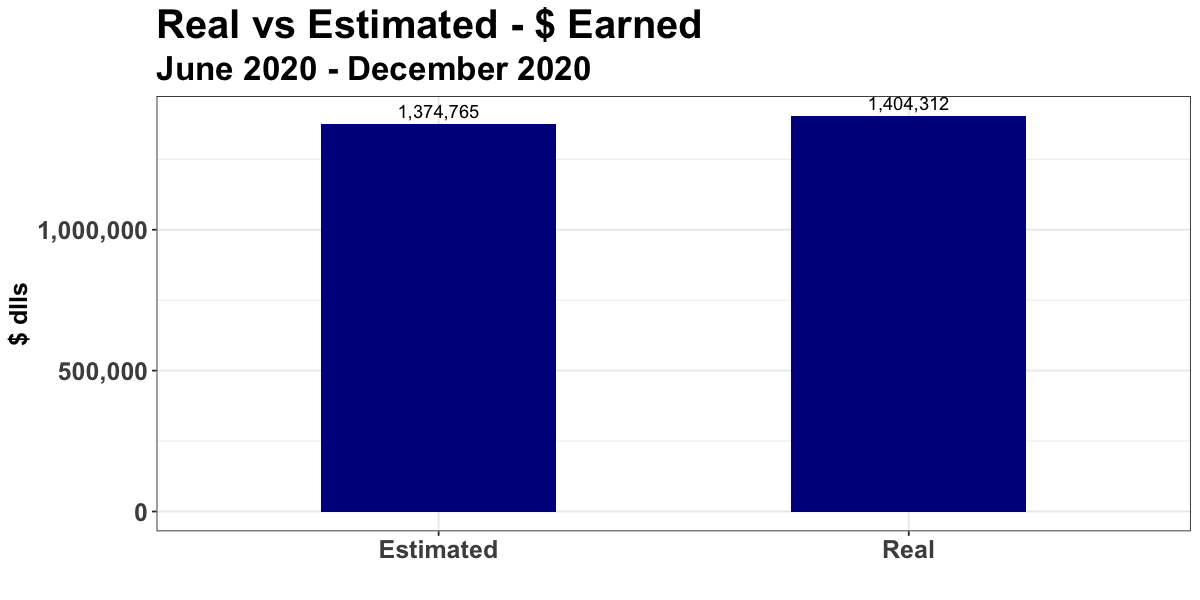

In [220]:
options(repr.plot.width=10, repr.plot.height=5)

data.frame(desc = c('Real', 'Estimated'),
           total = c(real,estimated)) %>%
 ggplot() +
 geom_col(aes(x = desc, y = total), fill = 'darkblue', width = 0.5) +
 theme_bw() +
 ggtitle('Real vs Estimated - $ Earned', subtitle = 'June 2020 - December 2020') +
 scale_y_continuous(labels = scales::comma) +
 xlab('') +
 ylab('$ dlls') +
 geom_text(aes(x = desc, y = total, label = scales::comma(total)), vjust = -0.5) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

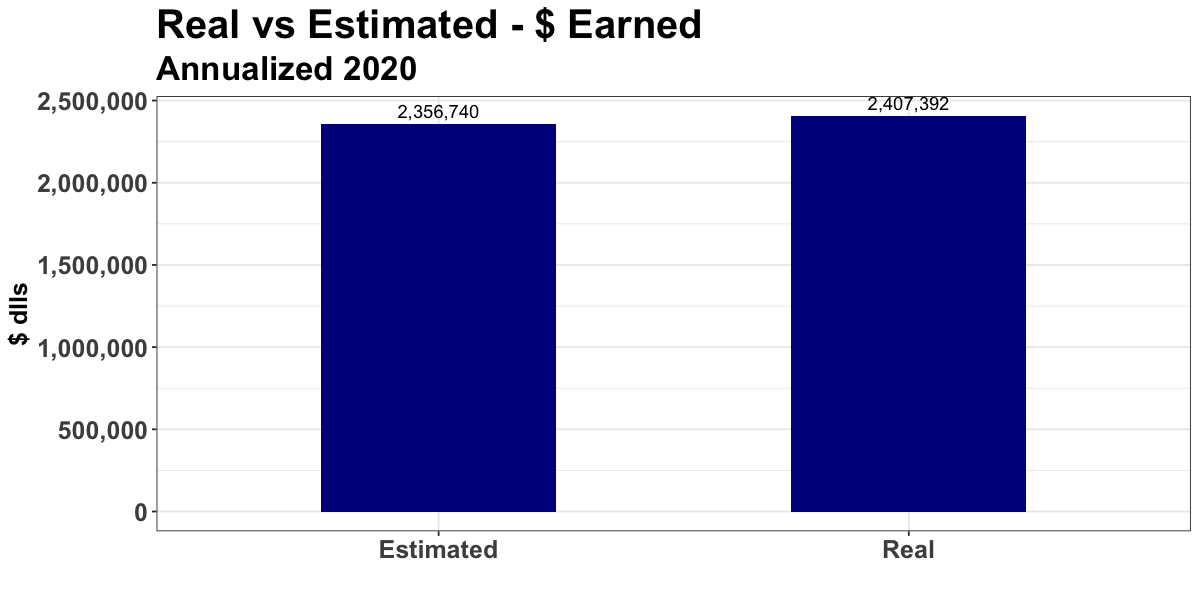

In [221]:
options(repr.plot.width=10, repr.plot.height=5)

data.frame(desc = c('Real', 'Estimated'),
           total = c(real_anual,estimated_anual)) %>%
 ggplot() +
 geom_col(aes(x = desc, y = total), fill = 'darkblue', width = 0.5) +
 theme_bw() +
 ggtitle('Real vs Estimated - $ Earned', subtitle = 'Annualized 2020') +
 scale_y_continuous(labels = scales::comma) +
 xlab('') +
 ylab('$ dlls') +
 geom_text(aes(x = desc, y = total, label = scales::comma(total)), vjust = -0.5) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

# Busines Case - Loan Amt

For this excercise, we will see the total of Loan Amount, using the real Loan Amount, and the estimated Loan Amount, using the buckets.

$$\text{Estimated Loan Amount}_{item} = Bucket_{item_{CategoryManu}}*\text{Real LTV}_{item}$$

In [222]:
data %>%
 left_join(buc, by = 'CategoryDesc') %>%
 mutate(Loan_amt_real = cost,
        Loan_amt_estimated = bucket*LTV) %>%
 filter(CategoryDesc %in% Manufacturer_Buckets$CategoryDesc) -> data_bc

In [223]:
real      <- sum(data_bc$Loan_amt_real)
estimated <- sum(data_bc$Loan_amt_estimated)

print(paste0('The real Total Loan Amount earned for items with Manufacturers with bucket assigned is: $', scales::comma(round(real))))
print(paste0('The estimated Total Loan amount earned for items with Manufacturers with bucket assigned is: $', scales::comma(round(estimated))))

[1] "The real Total Loan Amount earned for items with Manufacturers with bucket assigned is: $637,747"
[1] "The estimated Total Loan amount earned for items with Manufacturers with bucket assigned is: $627,109"


Annualize numbers:

We know that the numbers above are from June2020 - Dec2020 (7 months).

If we suppose is a uniform distribution of earnings, we can multiply those numbers by 12/7

In [1]:
real_anual <- real*(12/7)
estimated_anual <- estimated*(12/7)

print(paste0('The real Total Loan Amount, anualized, earned for items with Manufacturers with bucket assigned is: $', scales::comma(round(real_anual))))
print(paste0('The estimated Total Loan Amount, anualized, earned for items with Manufacturers with bucket assigned is: $', scales::comma(round(estimated_anual))))

ERROR: Error in eval(expr, envir, enclos): objeto 'real' no encontrado


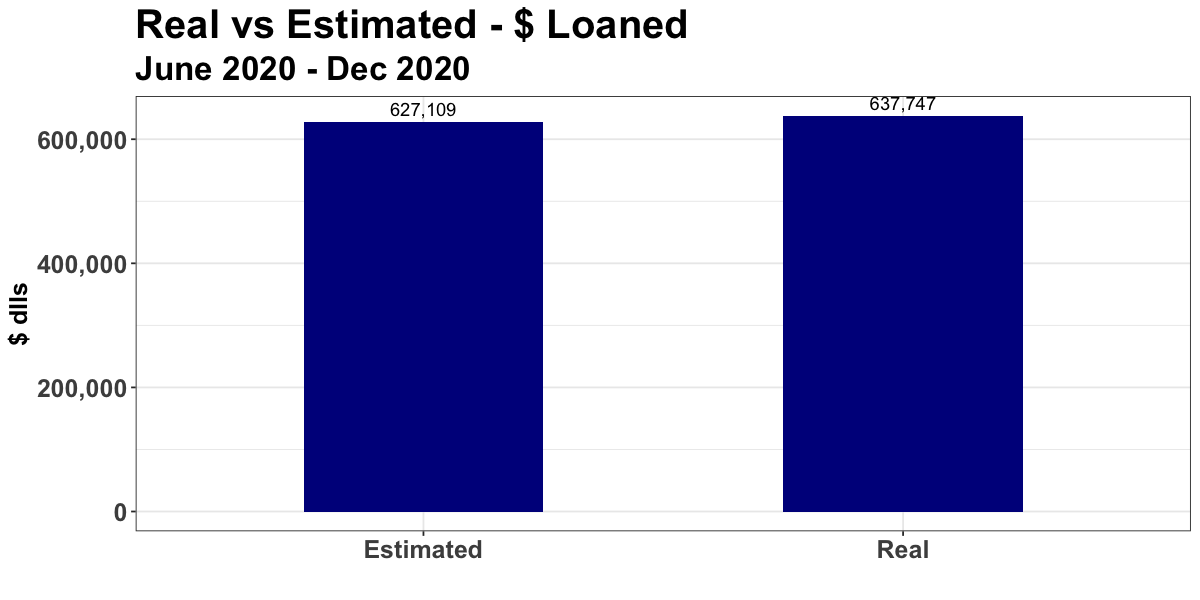

In [227]:
options(repr.plot.width=10, repr.plot.height=5)

data.frame(desc = c('Real', 'Estimated'),
           total = c(real,estimated)) %>%
 ggplot() +
 geom_col(aes(x = desc, y = total), fill = 'darkblue', width = 0.5) +
 theme_bw() +
 ggtitle('Real vs Estimated - $ Loaned', subtitle = 'June 2020 - Dec 2020') +
 scale_y_continuous(labels = scales::comma) +
 xlab('') +
 ylab('$ dlls') +
 geom_text(aes(x = desc, y = total, label = scales::comma(total)), vjust = -0.5) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

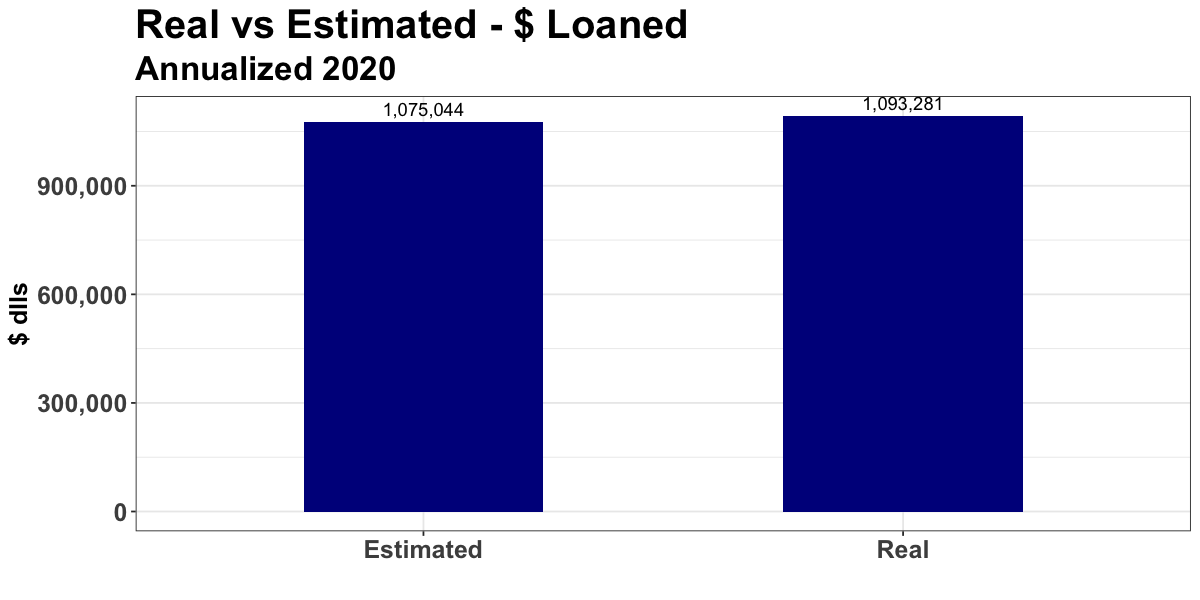

In [226]:
options(repr.plot.width=10, repr.plot.height=5)

data.frame(desc = c('Real', 'Estimated'),
           total = c(real_anual,estimated_anual)) %>%
 ggplot() +
 geom_col(aes(x = desc, y = total), fill = 'darkblue', width = 0.5) +
 theme_bw() +
 ggtitle('Real vs Estimated - $ Loaned', subtitle = 'Annualized 2020') +
 scale_y_continuous(labels = scales::comma) +
 xlab('') +
 ylab('$ dlls') +
 geom_text(aes(x = desc, y = total, label = scales::comma(total)), vjust = -0.5) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

# Business Case - % items priced

Get all items loaned/purchased in 2020, and get the percentage of dollars with items with a price assigned with the bucket.

This dropping the big categories

In [7]:
data2020 <- read_csv('/Users/darias/Documents/Bucket_Pricing/Data/LoansPurchase_Made_US2020.csv')

Parsed with column specification:
cols(
  .default = col_character(),
  primary_relation = col_double(),
  FiscalYear = col_double(),
  ItemID = col_double(),
  cost = col_double(),
  item_categorization = col_double(),
  Inventory_Days = col_double()
)

See spec(...) for full column specifications.



Drop big categories

In [8]:
x <- c(
'Video Game Console',
'Laptop',
'LED',
'Digital OLED TVs',
'LCD',
'Tablet',
'Smart Phones',
'Cellular Telephone',
'null',
'Shoes',
'NULL')

In [9]:
data2020 %>%
 filter(!(CategoryDesc %in% x)) -> data2020

Manufacturer in lowercase, without spaces

In [10]:
data2020 %>%
 mutate(Manufacturer = tolower(Manufacturer),
        Manufacturer = gsub(' ', '', Manufacturer)) -> data2020

Paste the Manufacturer and the CategoryDesc to create the Categories

In [11]:
data2020 %>%
 mutate(CategoryDesc_original = CategoryDesc,
        CategoryDesc          = paste0(Manufacturer,'-',CategoryDesc)) -> data2020

Add to the data an indicator, to see if the item has a bucket assigned

In [13]:
nrow(data2020)

[1] 1951082

In [15]:
un <- unique(Manufacturer_Buckets$CategoryDesc)

data2020 %>%
 mutate(ind_bucket = ifelse(CategoryDesc %in% un, 'Bucket', 'No Bucket')) -> data2020

## Items with bucket - Cases

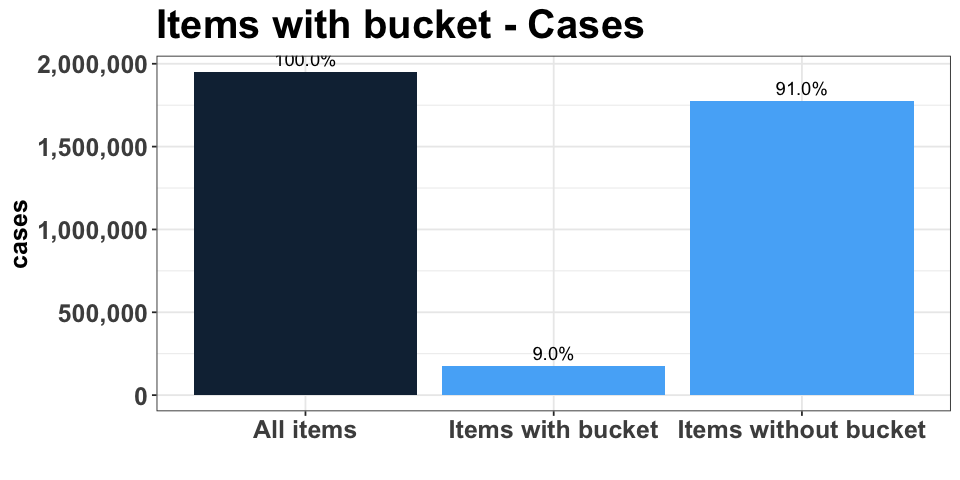

In [29]:
options(repr.plot.width=8, repr.plot.height=4)

total_items         <- nrow(data2020)
items_no_bucket     <- data2020 %>% filter(ind_bucket != 'Bucket') %>% nrow
items_bucket        <- data2020 %>% filter(ind_bucket == 'Bucket') %>% nrow
pct_items           <- 1
pct_items_no_bucket <- items_no_bucket/total_items
pct_items_bucket    <- items_bucket/total_items

data.frame(desc = c('All items','Items without bucket','Items with bucket'),
           cases = c(total_items,items_no_bucket,items_bucket),
           pct   = c(pct_items,pct_items_no_bucket,pct_items_bucket),
           colo  = c(1,2,2)) %>%
 ggplot() +
 geom_col(aes(x = desc, y = cases, fill = colo)) +
 theme_bw() +
 ggtitle('Items with bucket - Cases') +
 geom_text(aes(x = desc, y = cases, label = scales::percent(pct)), vjust = -0.5) +
 scale_y_continuous(labels = scales::comma) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'),
       legend.position = 'none') +
 xlab('')

## Items with bucket - Dlls Loan

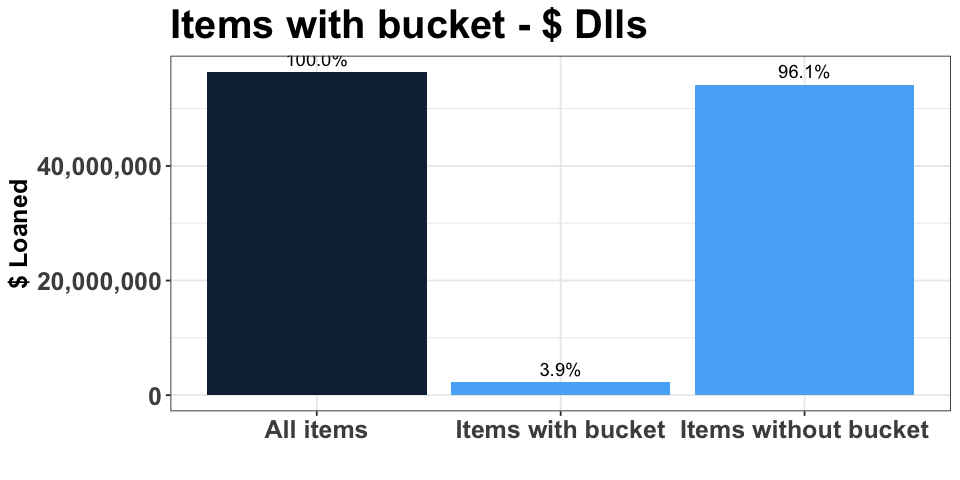

In [28]:
options(repr.plot.width=8, repr.plot.height=4)

total_items         <- sum(data2020$cost)
items_no_bucket     <- data2020 %>% filter(ind_bucket != 'Bucket') %>% select(cost) %>% pull %>% sum
items_bucket        <- data2020 %>% filter(ind_bucket == 'Bucket') %>% select(cost) %>% pull %>% sum
pct_items           <- 1
pct_items_no_bucket <- items_no_bucket/total_items
pct_items_bucket    <- items_bucket/total_items

data.frame(desc = c('All items','Items without bucket','Items with bucket'),
           cases = c(total_items,items_no_bucket,items_bucket),
           pct   = c(pct_items,pct_items_no_bucket,pct_items_bucket),
           colo  = c(1,2,2)) %>%
 ggplot() +
 geom_col(aes(x = desc, y = cases, fill = colo)) +
 theme_bw() +
 ggtitle('Items with bucket - $ Dlls') +
 geom_text(aes(x = desc, y = cases, label = scales::percent(pct)), vjust = -0.5) +
 scale_y_continuous(labels = scales::comma) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'),
       legend.position = 'none') +
 ylab('$ Loaned') +
 xlab('')